In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import datetime
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
store = pd.read_csv("./data/store.csv")
train = pd.read_csv("./data/train.csv",parse_dates=[2])
test = pd.read_csv("./data/test.csv",parse_dates=[3])
state = pd.read_csv("./data/store_states.csv")

#https://kb.bullseyelocations.com/support/solutions/articles/5000544642-germany-state-codes
weather_BW = pd.read_csv("./data/weather/BadenWürttemberg.csv", parse_dates=[0], sep = ';', engine = 'python')
weather_BW['State'] = 'BW'
weather_BY = pd.read_csv("./data/weather/Bayern.csv", parse_dates=[0], sep = ';')
weather_BY['State'] = 'BY'
weather_BE = pd.read_csv("./data/weather/Berlin.csv", parse_dates=[0], sep = ';')
weather_BE['State'] = 'BE'
#weather_BB = pd.read_csv("./data/weather/Brandenburg.csv", parse_dates=[1])
weather_HB = pd.read_csv("./data/weather/Bremen.csv", parse_dates=[0], sep = ';')
weather_HB['State'] = 'HB'
weather_HH = pd.read_csv("./data/weather/Hamburg.csv", parse_dates=[0], sep = ';')
weather_HH['State'] = 'HH'
weather_HE = pd.read_csv("./data/weather/Hessen.csv", parse_dates=[0], sep = ';')
weather_HE['State'] = 'HE'
#weather_MV = pd.read_csv("./data/weather/MecklenburgVorpommern.csv", parse_dates=[1])
weather_NW = pd.read_csv("./data/weather/NordrheinWestfalen.csv", parse_dates=[0], sep = ';')
weather_NW['State'] = 'NW'
weather_RP = pd.read_csv("./data/weather/RheinlandPfalz.csv", parse_dates=[0], sep = ';')
weather_RP['State'] = 'RP'
#weather_SL = pd.read_csv("./data/weather/Saarland.csv", parse_dates=[1])
weather_SN = pd.read_csv("./data/weather/Sachsen.csv", parse_dates=[0], sep = ';')
weather_SN['State'] = 'SN'
weather_ST = pd.read_csv("./data/weather/SachsenAnhalt.csv", parse_dates=[0], sep = ';')
weather_ST['State'] = 'ST'
weather_SH = pd.read_csv("./data/weather/SchleswigHolstein.csv", parse_dates=[0], sep = ';')
weather_SH['State'] = 'SH'
weather_TH = pd.read_csv("./data/weather/Thüringen.csv", parse_dates=[0], sep = ';', engine = 'python')
weather_TH['State'] = 'TH'

weather_combined = pd.concat([weather_BW,weather_BY,weather_BE,weather_HB,weather_HH,weather_HE,
                             weather_NW,weather_RP,weather_SN,weather_ST,weather_SH,weather_TH])

weather_combined.Events = weather_combined.Events.fillna('Normal')
weather_combined = weather_combined[['Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
                               'Max_Humidity','Mean_Humidity', 'Min_Humidity', 'Precipitationmm', 'Events','State']]



#Changing stores where state could not be unqiuely identified to Others(OT) category
state[state['State']=='HB,NI']['State']='OT'
store = store.merge(state, on = 'Store', how = 'left')
# merge data with store 
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

train = train.sort_values(['Date'],ascending = False)
train_full = train.copy()

# split the last 6 weeks data as validation set, just like our test dataset
#As per https://www.kaggle.com/c/rossmann-store-sales/discussion/18024
split_index = 6*7*1115
valid = train[:split_index] 
train = train[split_index:]

#valid = valid[(valid.Open != 0)&(valid.Sales >0)]
valid = valid.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False, False))
#train = train[(train.Open != 0)&(train.Sales >0)]
train = train.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False, False))
#train_full = train_full[(train_full.Open != 0)&(train_full.Sales >0)]
train_full = train_full.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False, False))
train_test_merged = pd.concat([train_full.sort_values('Date'), test.sort_values('Date')], axis = 0)
test = test.merge(weather_combined, on = ['Date','State'],  how = 'left', suffixes=(False, False))

train_full['Year']  = train_full['Date'].dt.year
train_full['Month'] = train_full['Date'].dt.month
train_full['WeekOfYear'] = train_full['Date'].dt.weekofyear

train_full['Promo2OpenInMonths'] = 12 * (train_full.Year - train_full.Promo2SinceYear) +\
                                    (train_full.WeekOfYear - train_full.Promo2SinceWeek) / 4.0
train_full['Promo2OpenInMonths'] = train_full['Promo2OpenInMonths'].apply(lambda x:x if x>0 else 0)
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
train_full['month_str'] = train_full.Month.map(month_dict)
def check_promo_month(row):
    '''Indicate whether the month is in promo interval'''
    if isinstance(row['PromoInterval'],str) and (row['month_str'] in row['PromoInterval']) \
    and (row['Promo2OpenInMonths']>0):
        return 1
    else:
        return 0
        
train_full['IsPromoMonth'] =  train_full.apply(lambda row: check_promo_month(row),axis=1) 

train_full['CompetitionOpenInMonths'] = 12 * (train_full.Year - train_full.CompetitionOpenSinceYear) + \
        (train_full.Month - train_full.CompetitionOpenSinceMonth)
train_full['CompetitionOpenInMonths'] = train_full['CompetitionOpenInMonths'].apply(lambda x: x if x > 0 else 0)

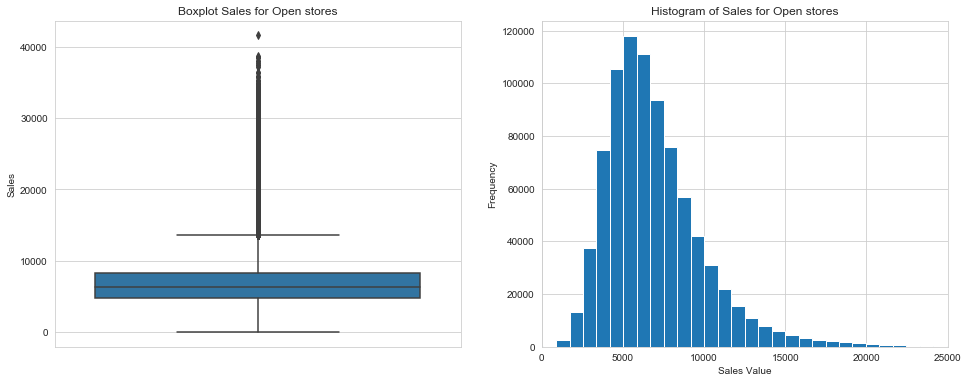

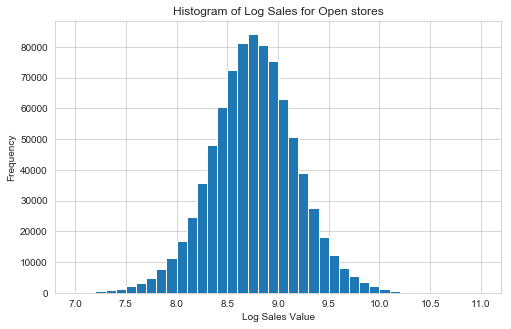

In [152]:
# Sales
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,6))
fig, (axis3) = plt.subplots(1,1,figsize=(8,5))
mask = train_full['Sales']>0
sns.boxplot(train_full[mask]["Sales"], orient='v', ax = axis1)
axis1.set_title("Boxplot Sales for Open stores")


train_full[mask]["Sales"].plot(kind='hist',bins=50,xlim=(0,25000), ax = axis2)
axis2.set_title("Histogram of Sales for Open stores")
axis2.set_xlabel('Sales Value')

axis3.hist(x = np.log(train_full[mask]["Sales"]), range=(7,11), bins=40)
axis3.set_title("Histogram of Log Sales for Open stores")
axis3.set_xlabel('Log Sales Value')
axis3.set_ylabel('Frequency')
plt.show()

1. Median sale is 6369 considering only stores that were open. There are some outliers in the sales data. 99% sales lies within 17789 and 99.9% sales are less than 24669. However there are values higher than 40000!
2. The dependent variable, sales is not normally distributed. Upon taking log transform we find that it is much closer to a normal distribution.

In [62]:
print("Median Sales:", np.median(train_full[mask]["Sales"]))
print("="*50)
print("75th percentile Sales:", np.quantile(train_full[mask]["Sales"], 0.75))
print("="*50)
for i in range(0,10):
    print('{}th percetile Sale is : {}'.format((90+i), np.quantile(train_full[mask]["Sales"], .9+i/100)))
print("="*50)
for i in range(0,10):
    print('{}th percetile Sale is : {}'.format((99+i/10), np.quantile(train_full[mask]["Sales"], .99+i/1000)))

Median Sales: 6369.0
75th percentile Sales: 8360.0
90th percetile Sale is : 10771.0
91th percetile Sale is : 11052.0
92th percetile Sale is : 11360.0
93th percetile Sale is : 11722.0
94th percetile Sale is : 12148.0
95th percetile Sale is : 12668.0
96th percetile Sale is : 13330.0
97th percetile Sale is : 14209.0
98th percetile Sale is : 15509.0
99th percetile Sale is : 17789.0
99.0th percetile Sale is : 17789.0
99.1th percetile Sale is : 18137.933999999892
99.2th percetile Sale is : 18494.304000000004
99.3th percetile Sale is : 18903.640999999945
99.4th percetile Sale is : 19362.0
99.5th percetile Sale is : 19908.314999999944
99.6th percetile Sale is : 20568.0
99.7th percetile Sale is : 21402.96699999983
99.8th percetile Sale is : 22571.304000000004
99.9th percetile Sale is : 24669.303999999538


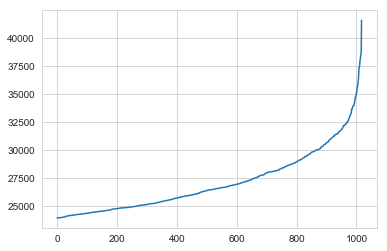

In [129]:
outliers = train_full[train_full["Sales"]>23979].sort_values('Sales')
x = np.arange(0,1018)
plt.plot(x, outliers['Sales'][:1018])

In [64]:
#train_full[train_full["Sales"]>33000]

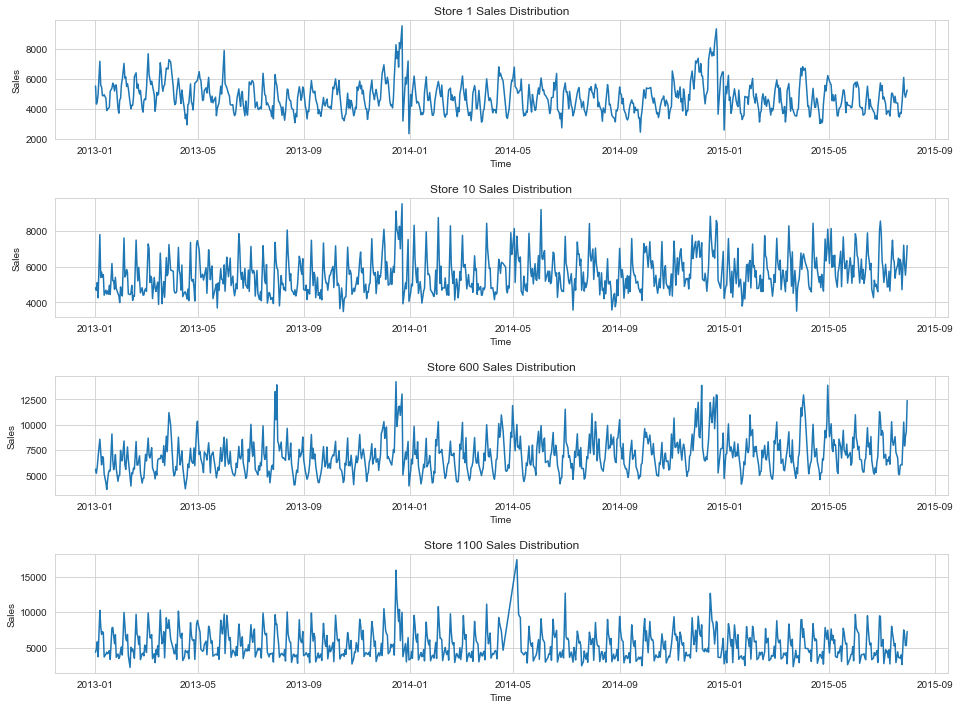

In [13]:
#https://www.kaggle.com/omarelgabry/a-journey-through-rossmann-stores
# Plotting store 1,10,600,1100 sales distribution plot
import matplotlib.pyplot as plt
store_1 = train_full.loc[(train_full["Store"]==1)&(train_full['Sales']>0) , ['Date',"Sales"]]
store_10 = train_full.loc[(train_full["Store"]==10)&(train_full['Sales']>0), ['Date',"Sales"]]
store_600 = train_full.loc[(train_full["Store"]==600)&(train_full['Sales']>0) ,['Date',"Sales"]]
store_1100 = train_full.loc[(train_full["Store"]==1100)&(train_full['Sales']>0) , ['Date',"Sales"]]
f = plt.figure(figsize=(16,12))
plt.subplots_adjust(hspace = 0.5)
ax1 = f.add_subplot(411)
ax1.plot(store_1['Date'], store_1['Sales'], '-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Sales')
ax1.set_title('Store 1 Sales Distribution')

ax2 = f.add_subplot(412)
ax2.plot(store_10['Date'], store_10['Sales'], '-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Sales')
ax2.set_title('Store 10 Sales Distribution')

ax2 = f.add_subplot(413)
ax2.plot(store_600['Date'], store_600['Sales'], '-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Sales')
ax2.set_title('Store 600 Sales Distribution')

ax2 = f.add_subplot(414)
ax2.plot(store_1100['Date'], store_1100['Sales'], '-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Sales')
ax2.set_title('Store 1100 Sales Distribution')

plt.show()

There is a pattern of sales over time for each of the stores which is evident from this time series plot. For some of the stores we can observe a peak in December month (probably Christmas time).

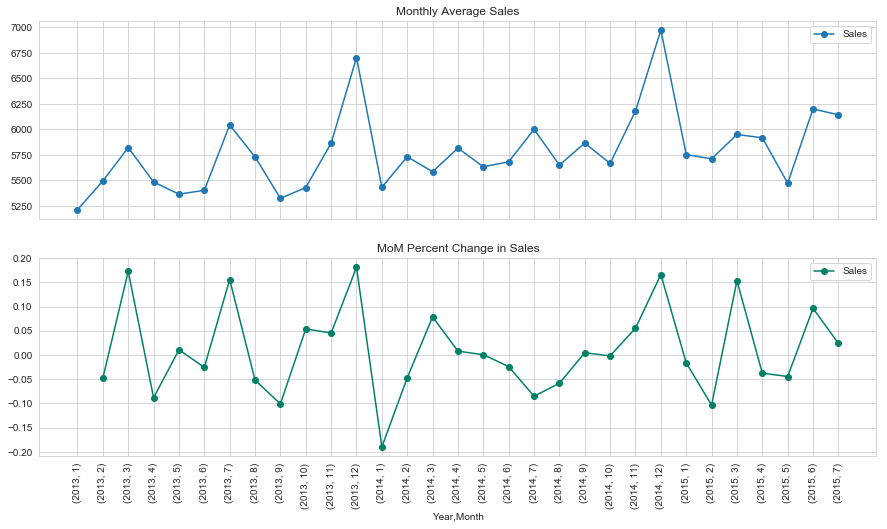

In [74]:
#https://www.kaggle.com/omarelgabry/a-journey-through-rossmann-stores

#test['Year']  = test['Date'].apply(lambda x: int(str(x)[:4]))
#test['Month'] = test['Date'].apply(lambda x: int(str(x)[5:7]))

# group by date and get average sales, and precent change
average_sales    = train_full.groupby(['Year', 'Month'])["Sales"].mean()
pct_change_sales = train_full.groupby(['Year', 'Month'])["Sales"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sales over time(year-month)
ax1 = average_sales.plot(legend=True,ax=axis1,marker='o',title="Monthly Average Sales")
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(), rotation=90)

# plot percent change for sales over time(year-month)
ax2 = pct_change_sales.plot(legend='True',ax=axis2,marker='o',rot=90,colormap="summer",title="MoM Percent Change in Sales")

There is evidence of peaks followed by troughs in monthly average sales. Almost for every steep rise in sales there is an immediate fall. A sharp rise in sales can be seen during end of the year and smaller spikes during the summer months (June-September).

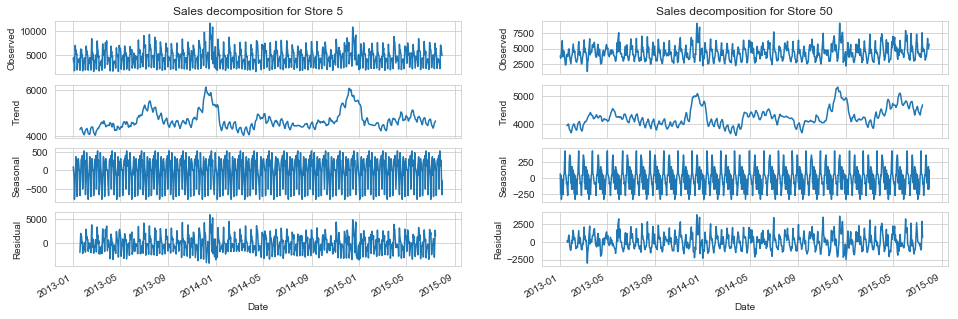

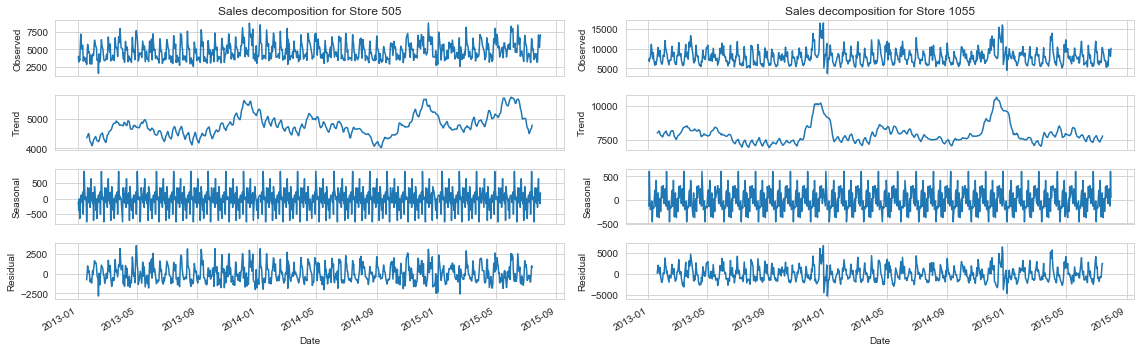

In [46]:
#https://stackoverflow.com/questions/45184055/how-to-plot-multiple-seasonal-decompose-plots-in-one-figure
def plotseasonal(res, axes, title):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    axes[0].set_title(title)


fig, axes1 = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,5))
fig, axes2 = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,5))

store_5 = train_full.loc[(train_full["Store"]==5)&(train_full['Sales']>0), ['Date',"Sales"]].set_index('Date')
store_50 = train_full.loc[(train_full["Store"]==50)&(train_full['Sales']>0), ['Date',"Sales"]].set_index('Date')
store_505 = train_full.loc[(train_full["Store"]==505)&(train_full['Sales']>0), ['Date',"Sales"]].set_index('Date')
store_1055 = train_full.loc[(train_full["Store"]==1055)&(train_full['Sales']>0), ['Date',"Sales"]].set_index('Date')

result5 = seasonal_decompose(store_5, model='additive', freq=30)
result50 = seasonal_decompose(store_50, model='additive', freq=30)
result505 = seasonal_decompose(store_505, model='additive', freq=30)
result1055 = seasonal_decompose(store_1055, model='additive', freq=30)

plotseasonal(result5, axes1[:,0], title = 'Sales decomposition for Store 5')
plotseasonal(result50, axes1[:,1], title = 'Sales decomposition for Store 50')
plotseasonal(result505, axes2[:,0], title = 'Sales decomposition for Store 505')
plotseasonal(result1055, axes2[:,1], title = 'Sales decomposition for Store 1055')

plt.tight_layout()
plt.show()

It becomes clear from the time series decompostion plot that there is a trend in sales as we progress over the years. For all the stores analysed above there is a sharp peak in sales during December. Seasonal trends can also be clearly observed.

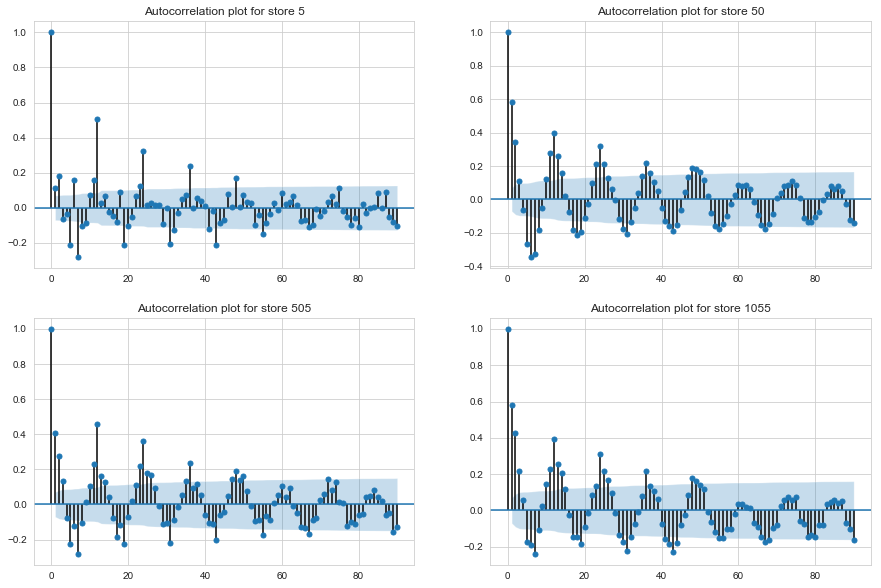

In [61]:
f = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace = 0.2)
ax1 = f.add_subplot(221)
plot_acf(store_5, lags = 90, ax= ax1, title = 'Autocorrelation plot for store 5')
ax2 = f.add_subplot(222)
plot_acf(store_50, lags = 90, ax= ax2, title = 'Autocorrelation plot for store 50')
ax3 = f.add_subplot(223)
plot_acf(store_505, lags = 90, ax= ax3, title = 'Autocorrelation plot for store 505')
ax4 = f.add_subplot(224)
plot_acf(store_1055, lags = 90, ax= ax4, title = 'Autocorrelation plot for store 1055')
plt.show()

Autocorelation at a certain lag defines how much the series at that lag is correlated with the original series. Any correltion within the blue region is negligible and can be ignored. Here we have considered upto 90 days lagged sales. For the stores above, the sales have significant correlation with lagged sales upto around 45 days (with high values at 10-14 days lag, 25-30 days lag and also around 35 and 45 days lagged sales).

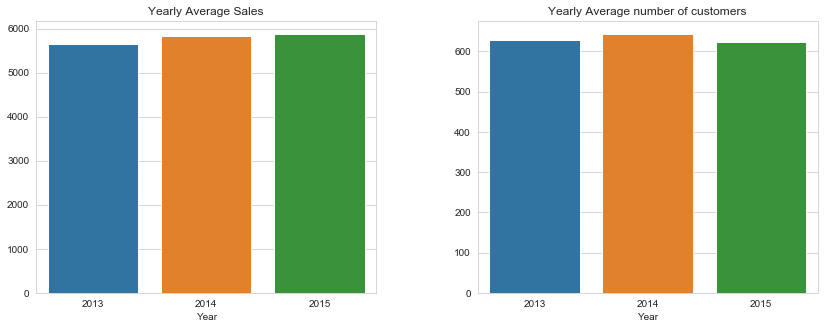

In [330]:
# Plot average sales & customers for every year
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
plt.subplots_adjust(wspace = 0.3)

df_y = train_full.groupby('Year')['Sales'].mean()
sns.barplot(x=df_y.index, y=df_y.values, ax=ax1)
ax1.set_xlabel('Year')
ax1.set_title('Yearly Average Sales')

df_y_c = train_full.groupby('Year')['Customers'].mean()
sns.barplot(x=df_y_c.index, y=df_y_c.values, ax=ax2)
ax2.set_xlabel('Year')
ax2.set_title('Yearly Average number of customers')
plt.show()

Average sales has increased as we progress over the years while average number of customers visiting has increased from 2013 to 2014. Since we have only around 7 months of data for 2015 its difficult to comment about 2015.

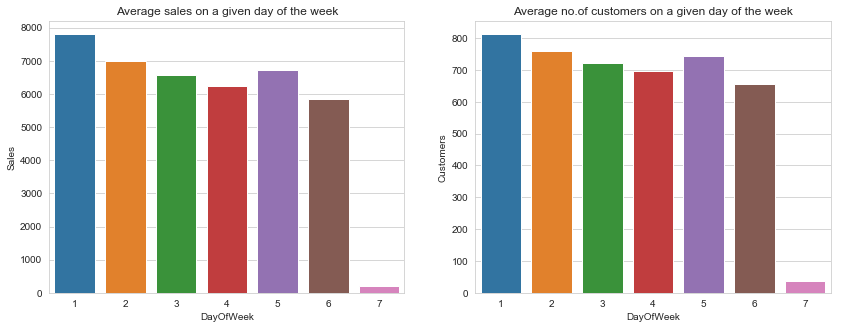

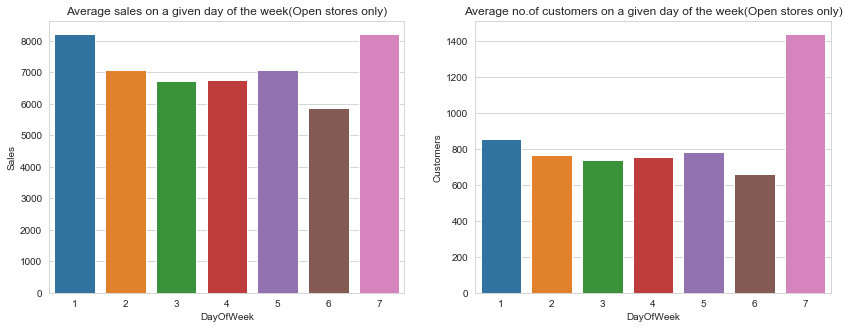

In [67]:
# DayOfWeek
# In both cases where the store is closed and opened
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
fig, (ax3,ax4) = plt.subplots(1,2,figsize=(14,5))
dw_df = train_full.groupby('DayOfWeek')['Sales'].mean()
dw_df_c = train_full.groupby('DayOfWeek')['Customers'].mean()
sns.barplot(x=dw_df.index, y=dw_df.values, ax=ax1)
ax1.set_title('Average sales on a given day of the week')
ax1.set_ylabel('Sales')
sns.barplot(x=dw_df_c.index, y=dw_df_c.values, ax=ax2)
ax2.set_title('Average no.of customers on a given day of the week')
ax2.set_ylabel('Customers')

dw_df = train_full[mask].groupby('DayOfWeek')['Sales'].mean()
dw_df_c = train_full[mask].groupby('DayOfWeek')['Customers'].mean()
sns.barplot(x=dw_df.index, y=dw_df.values, ax=ax3)
ax3.set_title('Average sales on a given day of the week(Open stores only)')
ax3.set_ylabel('Sales')
sns.barplot(x=dw_df_c.index, y=dw_df_c.values, ax=ax4)
ax4.set_title('Average no.of customers on a given day of the week(Open stores only)')
ax4.set_ylabel('Customers')
plt.show()

1. Most of the stores remain closed on sundays(day 7). So if we consider both opened and closed stores average Sunday sales are lowest.
2. But on the contrary if we consider Open stores only, Sunday and Monday (day 1) sales are among the highest. The number of customers visiting on Sundays are much more any other day on an average.

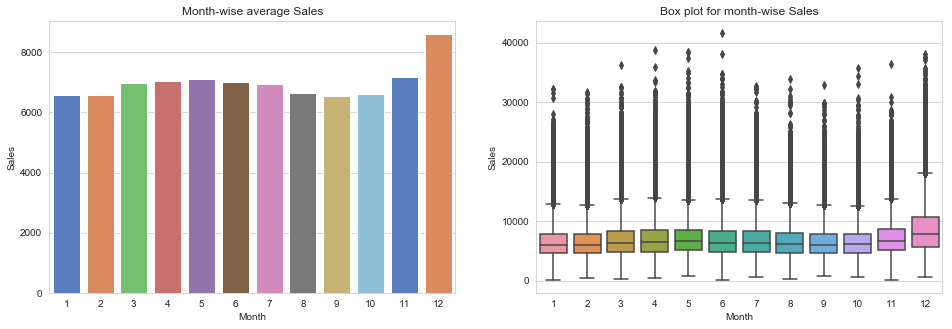

In [187]:
# Month of the year
# In both cases where the store is closed and opened
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
dw_m = train_full[mask].groupby('Month')['Sales'].mean()

sns.barplot(x=dw_m.index, y=dw_m.values, ax=ax1, palette='muted')
ax1.set_title('Month-wise average Sales')
ax1.set_ylabel('Sales')

dw_m_c = train_full[(train_full.Sales>0)&(train_full.Year!=2015)]
sns.boxplot(data = train_full[mask], x='Month', y='Sales', ax=ax2)
ax2.set_title('Box plot for month-wise Sales')
ax2.set_ylabel('Sales')
plt.show()

Maximum Sales occur during November and December. For other months the sales distribution is similar both in terms of median and variation. A slight increase in sales can be observed during the month of May.

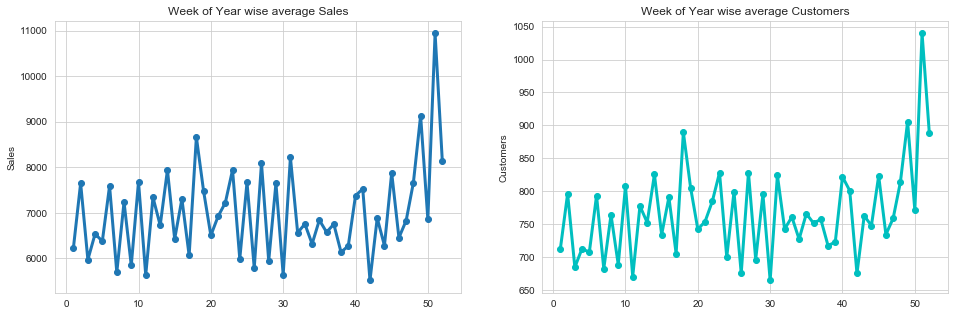

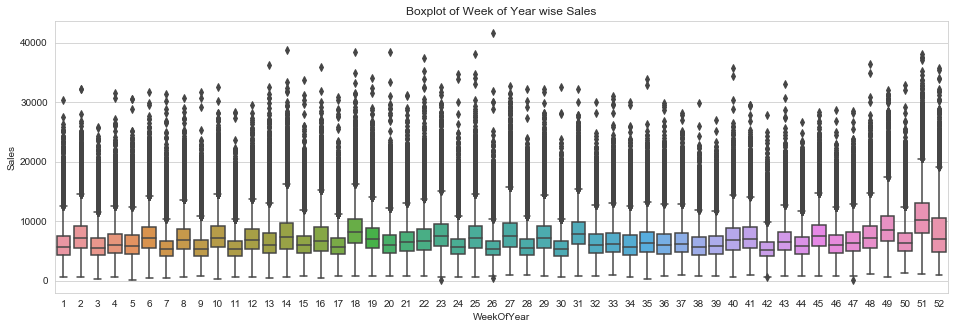

In [184]:
# Week of the year
# In both cases where the store is closed and opened
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
dw_m = train_full[mask].groupby('WeekOfYear')['Sales'].mean()
dw_mc = train_full[mask].groupby('WeekOfYear')['Customers'].mean()

ax1.plot(dw_m.index.tolist(), dw_m.values, '-', marker = 'o', linewidth = 3)
ax1.set_title('Week of Year wise average Sales')
ax1.set_ylabel('Sales')

ax2.plot(dw_mc.index.tolist(), dw_mc.values, '-', marker = 'o', linewidth = 3, color = 'c')
ax2.set_title('Week of Year wise average Customers')
ax2.set_ylabel('Customers')

fig, ax3 = plt.subplots(1,1,figsize=(16,5))
dw_m_c = train_full[(train_full.Sales>0)&(train_full.Year!=2015)]
sns.boxplot(data = train_full[mask], x='WeekOfYear', y='Sales', ax=ax3)
ax3.set_title('Boxplot of Week of Year wise Sales')
ax3.set_ylabel('Sales')
plt.show()

The week wise sales reveals highest sales during last 3-4 weeks. In some of the weeks in range 18-31 the sales are higher than most other weeks. The same story is true for the number of customers visiting the stores.

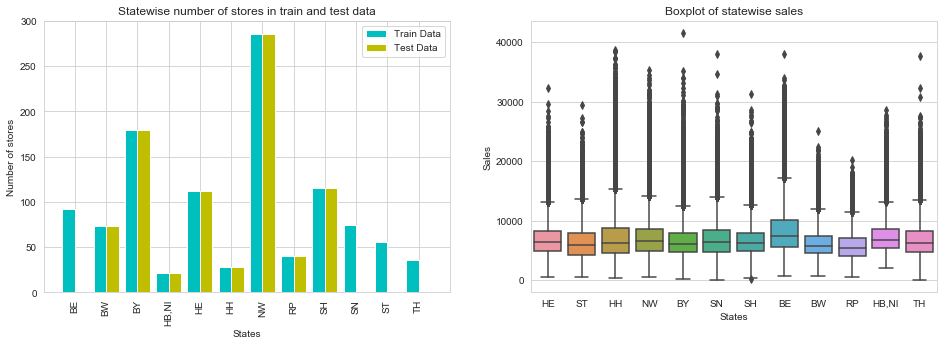

In [79]:
#States
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
width = 0.2
train_vals = train_full.groupby('State')['Store'].nunique()
indices = np.arange(len(train_vals))
test_vals = test.groupby('State')['Store'].nunique()
test_vals_updated = []
for ind in train_vals.index:
    if ind in test_vals.index:
        test_vals_updated.append(test_vals[ind])
    else:
        test_vals_updated.append(0)
ax1.bar(indices-width, train_vals.values , label = 'Train Data', width = 2*width, color = 'c', align = 'center')
ax1.bar(indices+width, test_vals_updated, label = 'Test Data', width = 2*width, color = 'y')
ax1.set_title('Statewise number of stores in train and test data')
ax1.set_xticks(indices)
ax1.set_xticklabels(train_vals.index, rotation='vertical')
ax1.set_ylabel('Number of stores')
ax1.set_xlabel('States')
ax1.legend()

sns.boxplot(data = train_full[mask], x='State', y='Sales', ax=ax2)
ax2.set_title('Boxplot of statewise sales')
ax2.set_xlabel('States')
plt.show()

1. In the test data there are no stores from 4 states BE, SN, ST and TH. For other sets the number of store in test and train data are equal. The maximum number of stores are in state NW.
2. Boxplot for statewise sales reveals that store in all states have comparable sales with BE having slightly higher median sales than others.

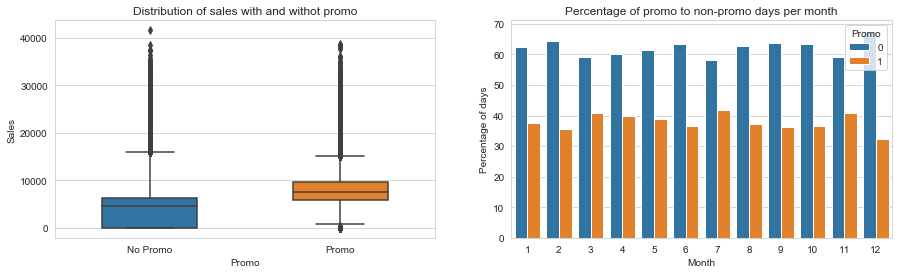

In [337]:
#https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group
# Plot average sales & customers with/without promo
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.boxplot(x='Promo', y='Sales', data=train_df, ax=axis1, width=0.5)
axis1.set_xticks([0,1])
axis1.set_xticklabels(['No Promo', 'Promo'])
axis1.set_title('Distribution of sales with and withot promo')

promo_month = (train_full.groupby(['Month'])['Promo']
                     .value_counts(normalize=True)
                     .rename('Percentage of days')
                     .mul(100)
                     .reset_index()
                     .sort_values('Month'))
sns.barplot(x="Month", y="Percentage of days", hue="Promo", data=promo_month, ax = axis2)
axis2.set_title('Percentage of promo to non-promo days per month')
plt.show()

Clearly sales is higher when there is promotions are given in a store. If we take a look a at the how the promotions are distributed over the months, we find that in any month (on an average) around 30-40% of the days (i.e. 10-12 days per month) the stores run promtional offers. However, it is higher for March, July and November and significantly lower in December.
This could be a strategy to even out sales over the months. The stores might increase promotion duration when the sales go down or to clear inventory before new sales cycle begins.

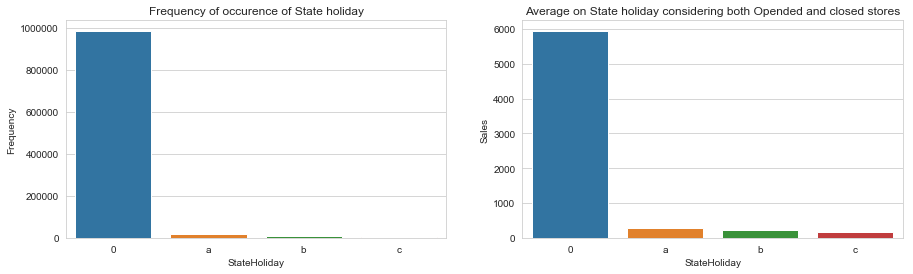

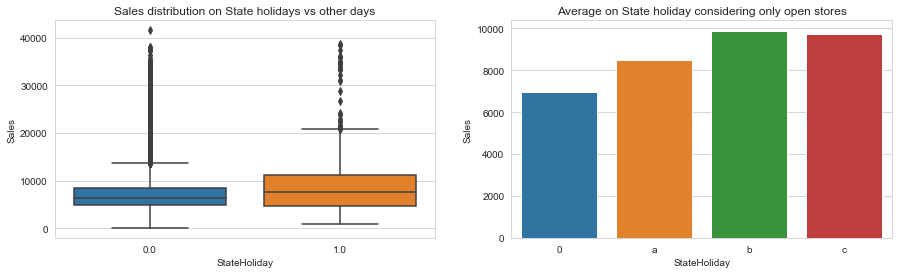

In [18]:
# StateHoliday
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
fig, (axis3,axis4) = plt.subplots(1,2,figsize=(15,4))
train_full["StateHoliday"].loc[train_full["StateHoliday"] == 0] = "0"
sth_df = train_full.groupby('StateHoliday')['Date'].count()
sns.barplot(sth_df.index, sth_df.values, ax = axis1)
axis1.set_ylabel('Frequency')
axis1.set_title('Frequency of occurence of State holiday')


sth_df_s = train_full.groupby('StateHoliday')['Sales'].mean()
sns.barplot(x=sth_df_s.index, y=sth_df_s.values, ax=axis2)
axis2.set_title('Average on State holiday considering both Opended and closed stores')
axis2.set_ylabel('Sales')

mask = train_full["Sales"] > 0
train_full_copy = train_full.copy()
train_full_copy["StateHoliday"] = train_full[mask]["StateHoliday"].apply(lambda x:0 if x=="0" else 1)
sns.boxplot(x='StateHoliday', y='Sales', data=train_full_copy, ax=axis3)
axis3.set_title('Sales distribution on State holidays vs other days')

sth_df_s=train_full[mask].groupby('StateHoliday')['Sales'].mean()
sns.barplot(x=sth_df_s.index, y=sth_df_s.values, ax=axis4)
axis4.set_ylabel('Sales')
axis4.set_title('Average on State holiday considering only open stores')
plt.show()

1. The number of state holidays of type 'a' are most frequent while type 'c' are least frequent.
2. Average sales on a state holidays are significantly less than other days. Further, it is lowest on a 'c' type state holiday as per the second graph.
3. But this data is potentially misleading. Beacuse when we consider only the stores open during a state holidays, the median sales is higher than a normal day.
4. Actually we can see that on all types of state holidays the average sales is higher than other days but as some of the stores remain closed on state holidays the second graph tells a deifferent story.

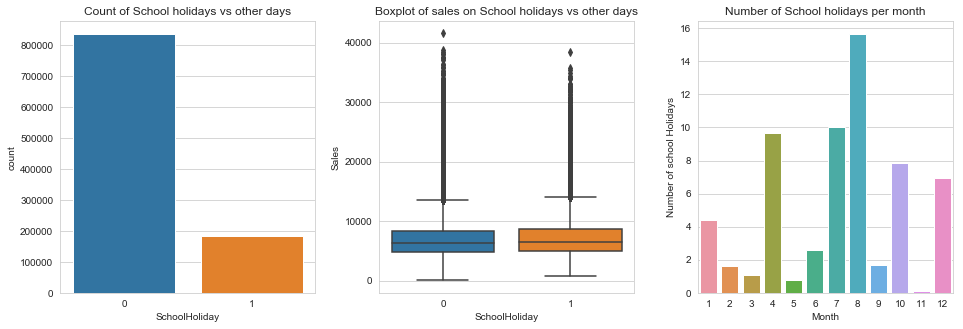

In [92]:
# SchoolHoliday

fig, (axis1,axis2, axis3) = plt.subplots(1,3,figsize=(16,5))
plt.subplots_adjust(wspace = 0.25)
sns.countplot(x='SchoolHoliday', data=train_full, ax = axis1)
axis1.set_title('Count of School holidays vs other days')
mask = mask = train_full["Sales"] > 0
sch_df = train_full[mask]

sns.boxplot(data = sch_df, x = 'SchoolHoliday', y = 'Sales', ax=axis2)
axis2.set_title('Boxplot of sales on School holidays vs other days')

sch_df_1 = (train_full[(train_full['SchoolHoliday']==1)&(train_full['Year']==2014)].groupby('Month')['SchoolHoliday']
                     .value_counts()
                     .div(1115)
                     .rename('Number of school Holidays')
                     .reset_index()
                     .sort_values('Month'))
sns.barplot(x="Month", y="Number of school Holidays", data=sch_df_1, ax = axis3)
axis3.set_title('Number of School holidays per month')
plt.show()

1. Sales on school holidays are very similar to other days. The median value on school holidays is slightly higher.
2. The last plot shows how the school holidays are distributed over the months for a particular year. The Months of July and August are summer holidays for school. There are also a winter break which is reflected by number of holidays in December. Apart from that there are some holidays in March and October. This is important because our test data lies in August and September.

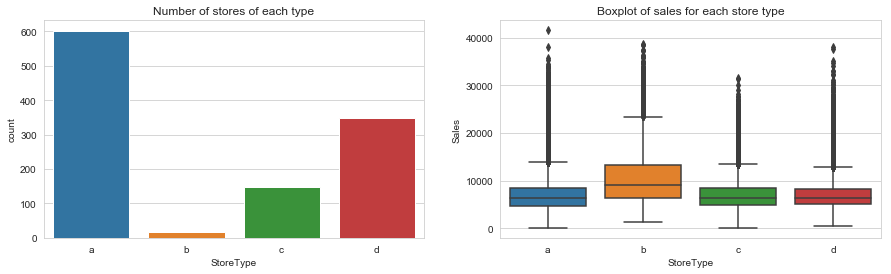

In [82]:
# StoreType 
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='StoreType', data=store, order=['a','b','c', 'd'], ax=axis1)
axis1.set_title('Number of stores of each type')

sns.boxplot(x='StoreType', y='Sales', data=train_full[mask], order=['a','b','c', 'd'],ax=axis2)
axis2.set_title('Boxplot of sales for each store type')
plt.show()

1. Stores of type 'a' are most frequently occuring while store type 'b' are least common.
2. Median sales in store types 'b' are significantly higher than other types of stores.

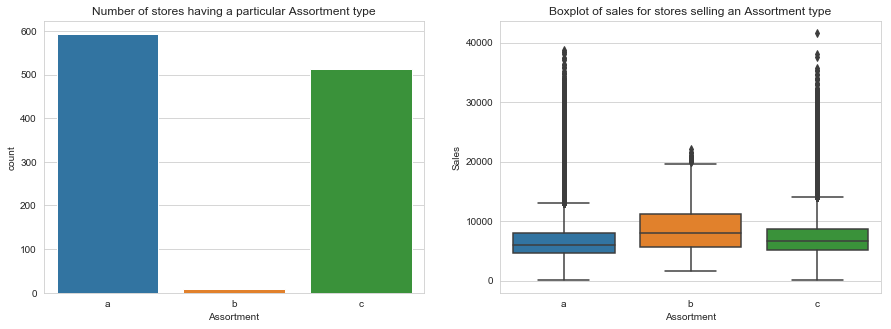

In [85]:
# Assortment  
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='Assortment', data=store, order=['a','b','c'], ax=axis1)
axis1.set_title('Number of stores having a particular Assortment type')

sns.boxplot(x='Assortment', y='Sales', data=train_full[mask], order=['a','b','c'],ax=axis2)
axis2.set_title('Boxplot of sales for stores selling an Assortment type')
plt.show()

1. Stores selling assortment type 'a' are most frequently occuring while stores selling assortment type 'b' are least common.
2. Median sales in store selling assortment 'b' are slightly higher than other stores.

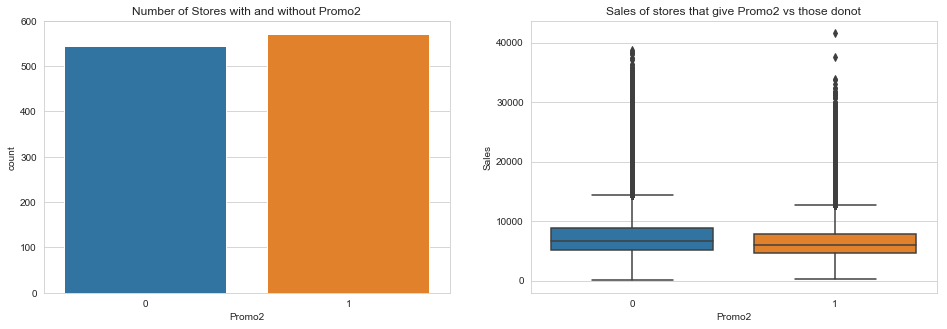

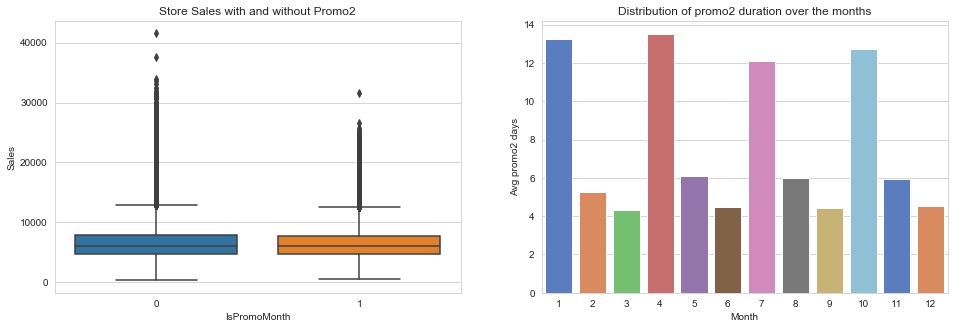

In [122]:
# Promo2
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,5))
fig, (axis3,axis4) = plt.subplots(1,2,figsize=(16,5))

sns.countplot(x='Promo2', data=store, ax = axis1)
axis1.set_title('Number of Stores with and without Promo2')

sns.boxplot(data=train_full[mask], x='Promo2', y='Sales', ax=axis2)
axis2.set_title('Sales of stores that give Promo2 vs those donot')

sns.boxplot(data=train_full[(train_full.Sales>0)&(train_full.Promo2>0)], x='IsPromoMonth', y='Sales', ax=axis3)
axis3.set_title('Store Sales with and without Promo2')

sch_df_1 = (train_full[(train_full['Year']!=2015)].groupby('Month')['IsPromoMonth']
                     .sum()
                     .div(575*2)
                     .rename('Avg promo2 days')
                     .reset_index()
                     .sort_values('Month'))
sns.barplot(x="Month", y="Avg promo2 days", data=sch_df_1, ax = axis4, palette='muted')
axis4.set_title('Distribution of promo2 duration over the months')
plt.show()

1. No. of stores participating in secondary promotions(promo 2) is slightly higher than the ones not participating.
2. Stores that do not participate in promo2 have higher sales than the ones that have promo2. So they might be trying to attract more customers by giving addtional promotions to increaase sales.
3. The next plot shows the sales of stores that give promo2 during two time periods, one during promo2 and one where there isn't. We can see that the sales are almost similar. So by giving the additional promotions these stores might be trying to increase the sale specially when they expect a dip in sale.
4. If we take a look at how the promo duration is distributed over the months. Most stores follow Jan, Apr, July, Oct cycle (i.e. Promo2 with a gap of 2 months).

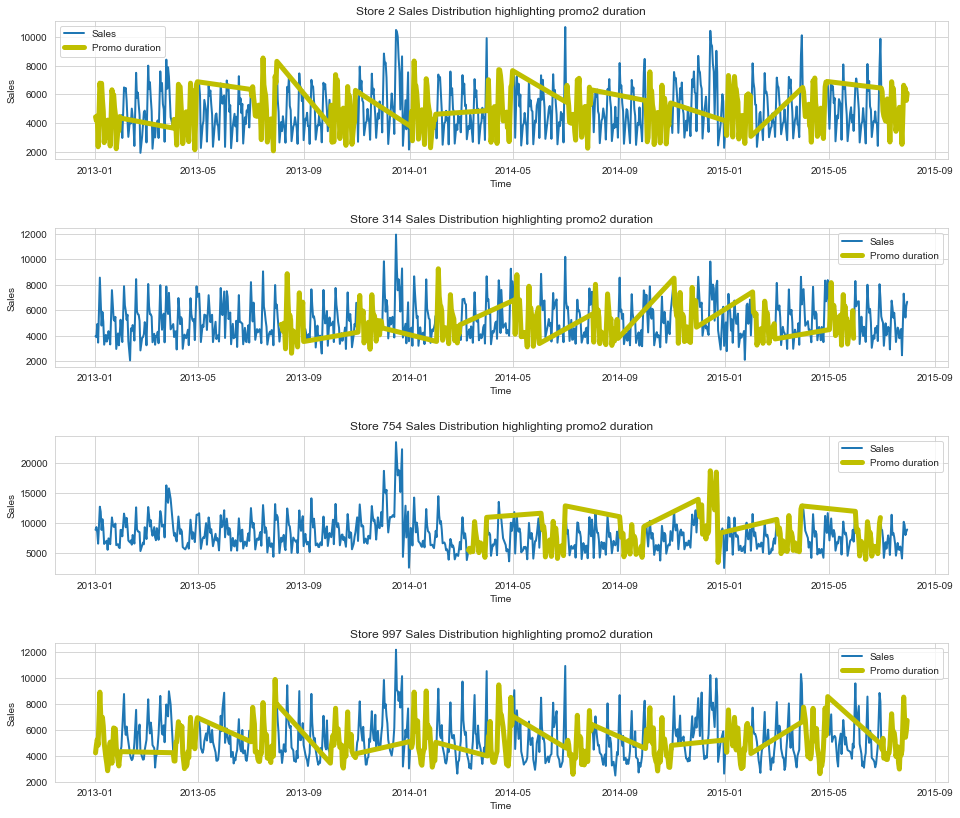

In [94]:
store_2 = train_full.loc[(train_full["Store"]==2)&(train_full['Sales']>0) , ['Date',"Sales",'IsPromoMonth']]

promo_duration = store_2.IsPromoMonth==1
f = plt.figure(figsize=(16,14))
plt.subplots_adjust(hspace = 0.5)
ax1 = f.add_subplot(411)
ax1.plot(store_2['Date'], store_2['Sales'], '-', linewidth=2)
ax1.plot(store_2[promo_duration]['Date'], store_2[promo_duration]['Sales'], 'y-', linewidth=5, label = 'Promo duration')
ax1.set_xlabel('Time')
ax1.set_ylabel('Sales')
ax1.legend()
ax1.set_title('Store 2 Sales Distribution highlighting promo2 duration')


store_314 = train_full.loc[(train_full["Store"]==314)&(train_full['Sales']>0) , ['Date',"Sales", 'IsPromoMonth']]
promo_duration = store_314["IsPromoMonth"]==1

ax2 = f.add_subplot(412)
ax2.plot(store_314['Date'], store_314['Sales'], '-', linewidth=2)
ax2.plot(store_314[promo_duration]['Date'], store_314[promo_duration]['Sales'], 'y-', linewidth=5, label = 'Promo duration')
ax2.set_xlabel('Time')
ax2.set_ylabel('Sales')
ax2.legend()
ax2.set_title('Store 314 Sales Distribution highlighting promo2 duration')


store_754 = train_full.loc[(train_full["Store"]==754)&(train_full['Sales']>0) , ['Date',"Sales", 'IsPromoMonth']]
promo_duration = store_754["IsPromoMonth"]==1

ax3 = f.add_subplot(413)
ax3.plot(store_754['Date'], store_754['Sales'], '-', linewidth=2)
ax3.plot(store_754[promo_duration]['Date'], store_754[promo_duration]['Sales'], 'y-', linewidth=5, label = 'Promo duration')
ax3.set_xlabel('Time')
ax3.set_ylabel('Sales')
ax3.legend()
ax3.set_title('Store 754 Sales Distribution highlighting promo2 duration')

store_997 = train_full.loc[(train_full["Store"]==997)&(train_full['Sales']>0) , ['Date',"Sales", 'IsPromoMonth']]
promo_duration = store_997["IsPromoMonth"]==1

ax4 = f.add_subplot(414)
ax4.plot(store_997['Date'], store_997['Sales'], '-', linewidth=2)
ax4.plot(store_997[promo_duration]['Date'], store_997[promo_duration]['Sales'], 'y-', linewidth=5, label = 'Promo duration')
ax4.set_xlabel('Time')
ax4.set_ylabel('Sales')
ax4.legend()
ax4.set_title('Store 997 Sales Distribution highlighting promo2 duration')

plt.show()

1. As can be seen from the time series plot, the promo2 occurs periodically and the periods vary from store to store.
2. In general, these promos occur not during peak sales. So probably these are given maintain the level of sales or to clear stocks.

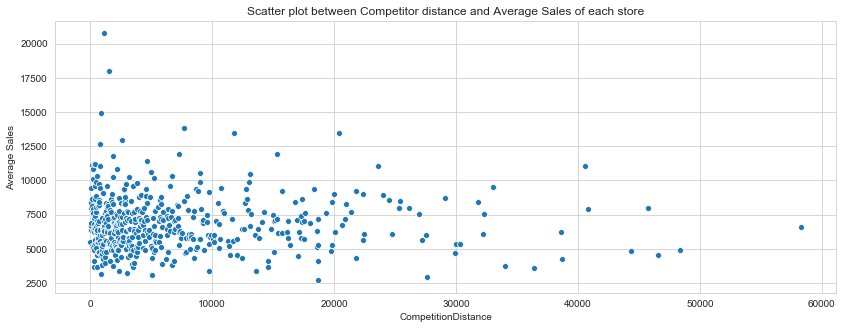

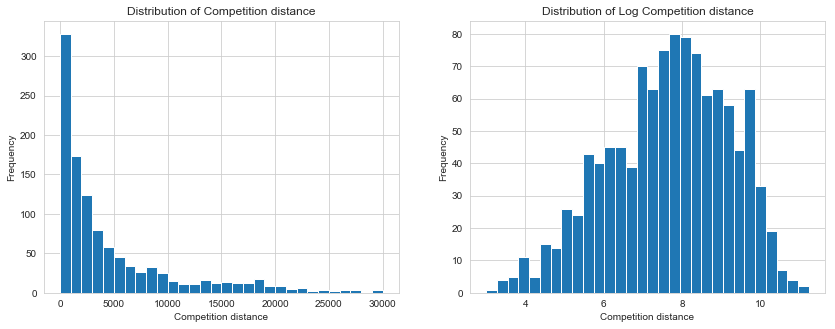

In [132]:
# CompetitionDistance
fig, axis1 = plt.subplots(1,1,figsize=(14,5))
fig, (axis2,axis3) = plt.subplots(1,2,figsize=(14,5))

# Plot CompetitionDistance Vs Sales
comp_df = train_full[(train_full['Sales']>0)&(~train_full['CompetitionDistance'].isna())&\
                    (train_full.CompetitionOpenInMonths>0)].groupby('CompetitionDistance')['Sales'].mean()
sns.scatterplot(x=comp_df.index,y=comp_df.values, ax = axis1)
axis1.set_ylabel('Average Sales')
axis1.set_title('Scatter plot between Competitor distance and Average Sales of each store')
axis2.hist(x = store['CompetitionDistance'].dropna(), bins = 30, range=(0,30000))
axis2.set_ylabel('Frequency')
axis2.set_xlabel('Competition distance')
axis2.set_title('Distribution of Competition distance')
axis3.hist(x = np.log(store['CompetitionDistance'].dropna()), bins = 30)
axis3.set_ylabel('Frequency')
axis3.set_xlabel('Competition distance')
axis3.set_title('Distribution of Log Competition distance')
plt.show()

1. The scatter plot between competition distance and Sales show that there is no apparent correlation between the Sales and the how far the competitor store is located.
2. The competition distance is not normally distributed. On taking log we find that it is closer to a normal distribution.

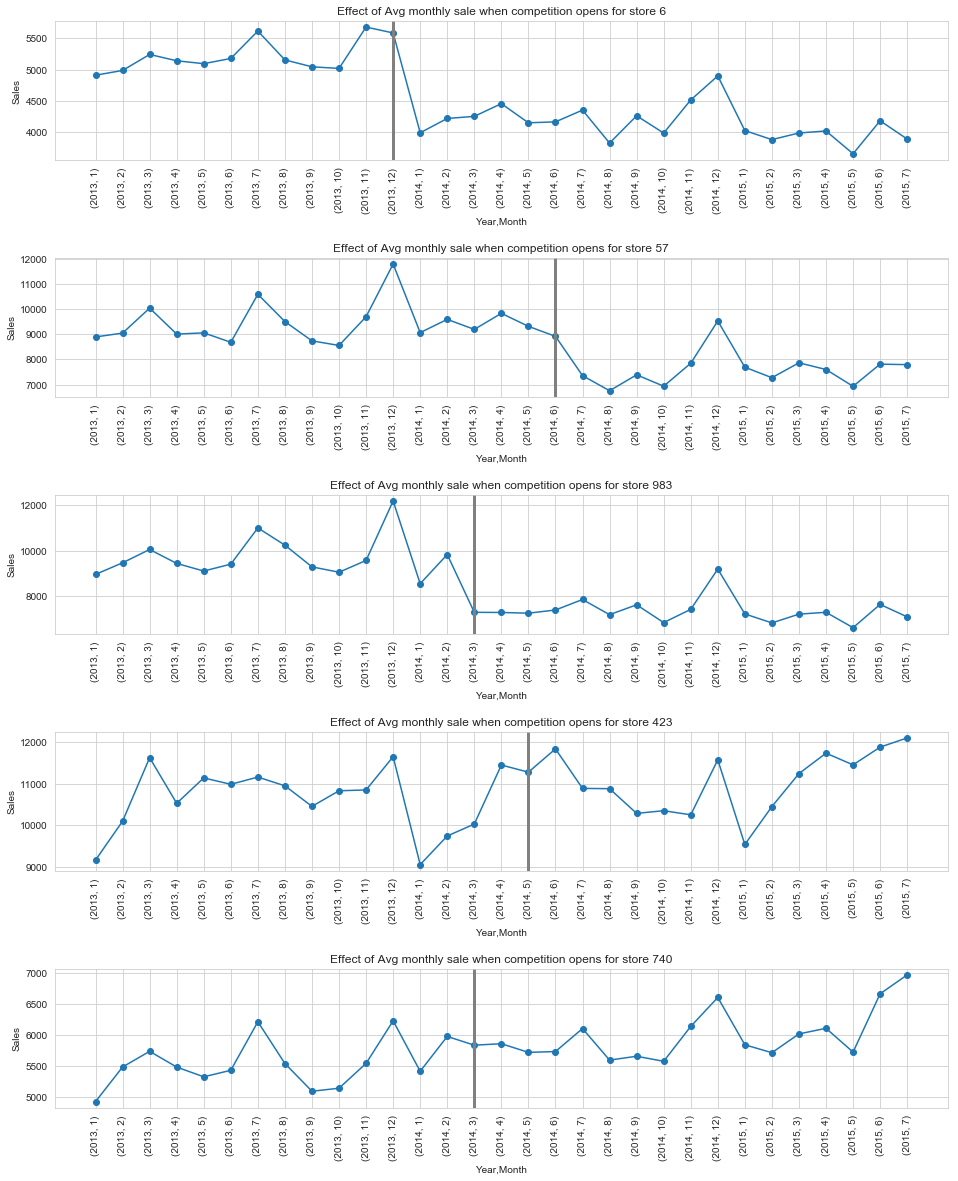

In [92]:
# What happened to the average sales of a store over time when competition started?
# Example: the average sales for store_id = 6 has dramatically decreased since the competition started

f = plt.figure(figsize=(16,20))
plt.subplots_adjust(hspace = 0.7)
store_data = train_full[train_full['Store'] == 6]
average_store_sales = store_data.groupby(['Year','Month'])['Sales'].mean()

axis1 = f.add_subplot(511)
axis1 = average_store_sales.plot(marker='o')
axis1.set_xticks(range(len(average_store_sales)))
axis1.set_xticklabels(average_store_sales.index.tolist(), rotation=90)

# Since all data of store sales given in rossmann_df starts with year=2013 till 2015,
# So, we need to check if year>=2013 and y & m aren't NaN values.
# Get year and month when Competition started
y = train_full["CompetitionOpenSinceYear"].loc[train_full["Store"]  == 6].values[0]
m = train_full["CompetitionOpenSinceMonth"].loc[train_full["Store"] == 6].values[0]

if y>=2013 and y == y and m == m:
    axis1.axvline(x=((y-2013) * 12) + (m - 1), linewidth=3, color='grey')

axis1.set_title('Effect of Avg monthly sale when competition opens for store 6')
axis1.set_ylabel('Sales')

store_data = train_full[train_full['Store'] == 57]
average_store_sales = store_data.groupby(['Year','Month'])['Sales'].mean()

axis2 = f.add_subplot(512)
axis2 = average_store_sales.plot(marker='o')
axis2.set_xticks(range(len(average_store_sales)))
axis2.set_xticklabels(average_store_sales.index.tolist(), rotation=90)

y = train_full["CompetitionOpenSinceYear"].loc[train_full["Store"]  == 57].values[0]
m = train_full["CompetitionOpenSinceMonth"].loc[train_full["Store"] == 57].values[0]

if y>=2013 and y == y and m == m:
    axis2.axvline(x=((y-2013) * 12) + (m - 1), linewidth=3, color='grey')

axis2.set_title('Effect of Avg monthly sale when competition opens for store 57')
axis2.set_ylabel('Sales')

store_data = train_full[train_full['Store'] == 983]
average_store_sales = store_data.groupby(['Year','Month'])['Sales'].mean()

axis3 = f.add_subplot(513)
axis3 = average_store_sales.plot(marker='o')
axis3.set_xticks(range(len(average_store_sales)))
axis3.set_xticklabels(average_store_sales.index.tolist(), rotation=90)
axis3.set_title('Effect of Avg monthly sale when competition opens for store 983')
axis3.set_ylabel('Sales')

y = train_full["CompetitionOpenSinceYear"].loc[train_full["Store"]  == 983].values[0]
m = train_full["CompetitionOpenSinceMonth"].loc[train_full["Store"] == 983].values[0]

if y>=2013 and y == y and m == m:
    axis3.axvline(x=((y-2013) * 12) + (m - 1), linewidth=3, color='grey')
    
    
store_data = train_full[train_full['Store'] == 423]
average_store_sales = store_data.groupby(['Year','Month'])['Sales'].mean()

axis4 = f.add_subplot(514)
axis4 = average_store_sales.plot(marker='o')
axis4.set_xticks(range(len(average_store_sales)))
axis4.set_xticklabels(average_store_sales.index.tolist(), rotation=90)
axis4.set_title('Effect of Avg monthly sale when competition opens for store 423')
axis4.set_ylabel('Sales')

y = train_full["CompetitionOpenSinceYear"].loc[train_full["Store"]  == 423].values[0]
m = train_full["CompetitionOpenSinceMonth"].loc[train_full["Store"] == 423].values[0]

if y>=2013 and y == y and m == m:
    axis4.axvline(x=((y-2013) * 12) + (m - 1), linewidth=3, color='grey')


store_data = train_full[train_full['Store'] == 740]
average_store_sales = store_data.groupby(['Year','Month'])['Sales'].mean()

axis5 = f.add_subplot(515)
axis5 = average_store_sales.plot(marker='o')
axis5.set_xticks(range(len(average_store_sales)))
axis5.set_xticklabels(average_store_sales.index.tolist(), rotation=90)
axis5.set_title('Effect of Avg monthly sale when competition opens for store 740')
axis5.set_ylabel('Sales')

y = train_full["CompetitionOpenSinceYear"].loc[train_full["Store"]  == 740].values[0]
m = train_full["CompetitionOpenSinceMonth"].loc[train_full["Store"] == 740].values[0]

if y>=2013 and y == y and m == m:
    axis5.axvline(x=((y-2013) * 12) + (m - 1), linewidth=3, color='grey')
    
plt.show()

The plots show the effect of a competitor opening shop in the neighborhood on monthly average sales.
1. For the first 3 stores (6,57,983) the sales have shown a downward trend after the competition opened. It is to be noted that the distance from competitor was lower for these stores.
2. For the next two stores (423, 740) the sales did not have much effect when the competitor opened because they were not in the vicinity of the store.

<h2>EDA Observations</h2>

1. Median sale is 6369 considering only stores that were open. There are some outliers in the sales data. 99% sales lies within 17789 and 99.9% sales are less than 24669. However there are values higher than 40000!
2. The dependent variable, sales is not normally distributed. Upon taking log transform, we find that it is much closer to a normal distribution.
3.  There is evidence of peaks followed by troughs in monthly average sales. Almost for every steep rise in sales there is an immediate fall. A sharp rise in sales can be seen during end of the year and smaller spikes during the summer months (June-September). Seasonal trends can also be observed.
4. Autocorrelation at a certain lag defines how much the series at that lag is correlated with the original series. For the stores above, the sales have significant correlation with lagged sales up to around 45 days (with high values at 10-14 days lag, 25-30 days lag and also around 35 and 45 days lagged sales).
5. Average sales has increased as we progress over the years while average number of customers visiting has increased from 2013 to 2014. Since we have only around 7 months of data for 2015 its difficult to comment about 2015.
6. Most of the stores remain closed on Sundays. So if we consider both opened and closed stores average Sunday sales are lowest.
7. But on the contrary if we consider Open stores only, Sunday and Monday (day 1) sales are among the highest. The number of customers visiting on Sundays are much more any other day on an average.
8. In the test data there are no stores from 4 states BE, SN, ST and TH. For other sets the number of store in test and train data are equal. The maximum number of stores are in state NW. All states have comparable sales with BE having slightly higher median sales than others.
9. Sales is generally higher when there is promotions are given in a store. In any month (on an average) around 30-40% of the days (i.e. 10-12 days per month) the stores run promotional offers. However, it is higher for March, July and November and significantly lower in December. This could be a strategy to even out sales over the months. The stores might increase promotion duration when the sales go down or to clear inventory before new sales cycle begins.
10. The number of state holidays of type 'a' are most frequent while type 'c' are least frequent. 
11.  On all types of state holidays the average sales is higher than other days. But if we take into account both open and closed stores we find that average sales is lower on a state holiday which is not true because some of the stores remain closed on state holidays.
12. Sales on school holidays are very similar to other days. The median value on school holidays is slightly higher.
13. The months of July and August are summer holidays for school. This is important because our test data lies in August and September. There are also a winter break which is reflected by number of holidays in December. Apart from that, there are some school holidays in March and October. 
14. Stores of type 'a' are most frequently occurring while store type 'b' are least common. Median sales in store types 'b' are significantly higher than other types of stores.
15. Stores selling assortment type 'a' are most frequently occurring while stores selling assortment type 'b' are least common. Median sales in store selling assortment 'b' are slightly higher than other stores.
16. Number of stores participating in secondary promotions (promo 2) is slightly higher than the ones not participating. 
17. Stores that do not participate in promo2 have higher sales than the ones that have promo2. So, they might be trying to attract more customers by giving additional promotions to increase sales.
18. For periods when there is a promo 2 and when there isn’t the sales are almost similar. So by giving the additional promotions these stores might be trying to increase the sale specially when they expect a dip in sale. Most stores follow Jan, Apr, July, Oct cycle (i.e. Promo2 with a gap of 2 months).
19. There is no apparent correlation between sales and the how far the competitor store is located. The competition distance is not normally distributed. On taking logarithm, we find that it is closer to a normal distribution.
20. When a competitor opens store in the neighbourhood of a Rossmann store, the monthly sales of the store generally shows a downward trend.
